In [12]:
import torch
import taibackdoor
from taibackdoor.model_zoo.cifar10_zoo import load_cifar10_model_and_data
from taibackdoor.detections.cognitive_distillation import CognitiveDistillation


# Let's load a prertained backdoor model and data

In [13]:

model_data_dict = load_cifar10_model_and_data("ResNet18-BadNets-PR0.1", download=False)
model = model_data_dict["model"].to('mps')
train_data = model_data_dict["train_data"]



Files already downloaded and verified
Injecting Over: 5000 Bad Imgs, 45000 Clean Imgs, Poison Rate (0.10)
Files already downloaded and verified
Injecting Over: 9000 Bad Imgs, 0 Clean Imgs, Poison Rate (1.00)


# Let's check some images

In [14]:
import torchvision
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline


def mask_to_heatmap(mask):
    heatmap = cm.get_cmap('Blues')
    return heatmap(mask.numpy())


def show_image_grid(imgs, nrow=10):
    grid_img = torchvision.utils.make_grid(imgs, nrow=nrow)
    fig= plt.figure(figsize=(10, 500), dpi=80)
    plt.imshow(grid_img.permute(1, 2, 0).detach().cpu().numpy())
    plt.show()
    plt.close()

In [15]:
poison_idx = model_data_dict['train_poison_idx']
clean_idx = np.array(list(set(range(len(train_data))) - set(poison_idx)))


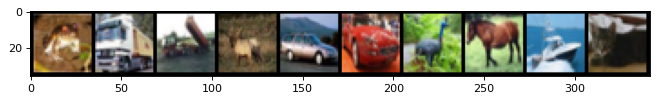

In [16]:
clean_imgs = []
for i in clean_idx[:10]:
    clean_imgs.append(train_data[i][0])
clean_imgs = torch.stack(clean_imgs)
show_image_grid(clean_imgs)

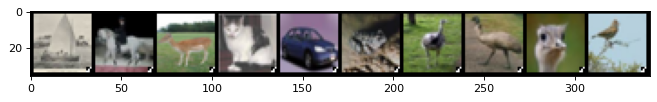

In [17]:
poison_imgs = []
for i in poison_idx[:10]:
    poison_imgs.append(train_data[i][0])
poison_imgs = torch.stack(poison_imgs)
show_image_grid(poison_imgs)

# Run Cognitive Distillation

In [18]:
detector = CognitiveDistillation(lr=0.1, p=1, gamma=0.01, beta=10.0, num_steps=100)
clean_masks = detector(model, clean_imgs.to('mps')) # the extracted masks (torch.Tensor) [b,1,h,w]

In [19]:
poison_masks = detector(model, poison_imgs.to('mps')) # the extracted masks (torch.Tensor) [b,1,h,w]

In [20]:
print(torch.norm(clean_masks, p=1, dim=[1, 2, 3]).mean(), 
      torch.norm(poison_masks, p=1, dim=[1, 2, 3]).mean(),)

tensor(229.6650) tensor(72.4296)


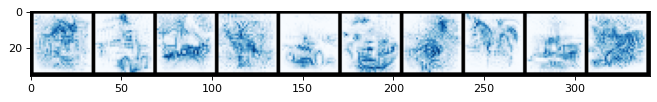

In [21]:
mask_display = clean_masks.view(-1, 32, 32)
mask_display = torch.stack([torch.tensor(mask_to_heatmap(mask_display[i, :, :]))for i in range(len(mask_display))])
mask_display = mask_display.permute(0, 3, 1, 2)[:, :3, :, :]
show_image_grid(mask_display)

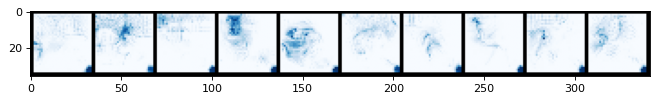

In [22]:
mask_display = poison_masks.view(-1, 32, 32)
mask_display = torch.stack([torch.tensor(mask_to_heatmap(mask_display[i, :, :]))for i in range(len(mask_display))])
mask_display = mask_display.permute(0, 3, 1, 2)[:, :3, :, :]
show_image_grid(mask_display)